오늘은 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해보았습니다.


In [1]:
import pandas
import tensorflow

from datetime import datetime as dt
# import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


# Step 1. 데이터의 전처리

## 1-1. Time 컬럼을 yyyy-mm-dd형식으로 변경해 주었습니다

In [3]:
oldest, latest = data['Time'].min(), data['Time'].max()

In [4]:
oldest

956703932

In [5]:
print(dt.fromtimestamp(oldest).strftime("%Y-%m-%d %H:%M:%S"))

2000-04-25 23:05:32


In [6]:
# test_time = pd.to_datetime(data['Time'])
test_time = data['Time']
for idx, time in enumerate(test_time):
    test_time[idx] = dt.fromtimestamp((time)).strftime("%Y-%m-%d %H:%M:%S")
# # test_time.dt.hour
# test_time.dt.date
# test_time[0]

In [7]:
test_time = pd.DataFrame(test_time)

In [8]:
test_time

,Time
0,2000-12-31 22:12:40
1,2000-12-31 22:35:09
2,2000-12-31 22:32:48
3,2000-12-31 22:04:35
4,2001-01-06 23:38:11
...,...
1000204,2000-04-26 02:35:41
1000205,2000-04-25 23:21:27
1000206,2000-04-25 23:19:06
1000207,2000-04-26 02:20:48


In [9]:
data['Time'] = test_time

In [10]:
del test_time

In [11]:
data['Time'].describe()

count                 1000209
unique                 458455
top       2000-11-29 20:06:42
freq                       30
Name: Time, dtype: object

## 1-2. 영화 추천을 위해서는, 평점이 3점 이상인 것만 남겨주었습니다.

아래 cleansing 메소드로 대체해서 사용 \^_\^

In [12]:
# data = data[data['Rating']>=3]

In [13]:
# data['Rating'].describe()

## 1-3. Session ID 필터링

In [14]:
# from pandas_visual_analysis import VisualAnalysis

In [15]:
# VisualAnalysis(data)

In [16]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [17]:
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [18]:
session_length.median()

96.0

# 세션의 길이 최소 : 1, 중간값 : 81, 평균 : 138, 최대 : 1968

1. A 작품을 보고, B작품도 보았다 라는 추천을 하기 위해선, session 길이가 2이상인 것만 남겨주려합니다.
2. 중간값은 81, 평균은 138입니다. 사용자 75%선의 Session 길이가 177입니다. 저는 사용자 75%의 데이터만 남겨주고 그 이상은 삭제할것입니다.

그전에 Session 길이에 대한 감을 잘 파악하기 위해 시각화를 시도해보았습니다.

In [19]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

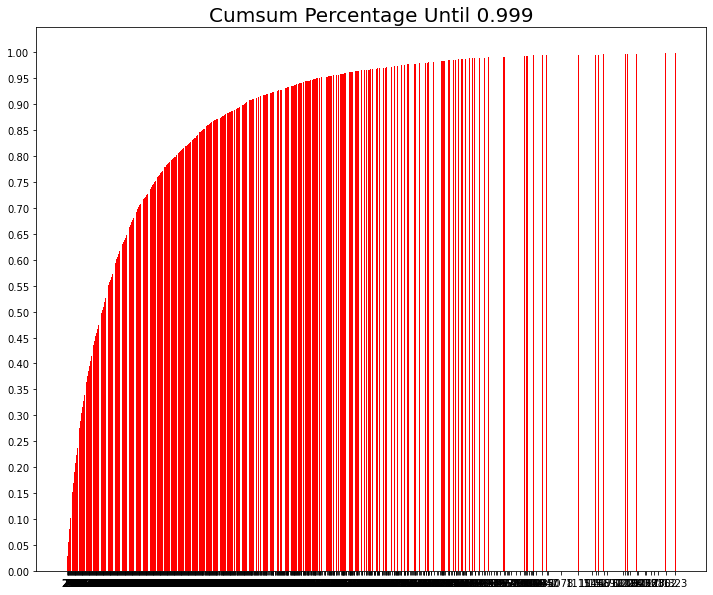

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

# Datathon의 영향으로, x축의 라벨값을 좋게 보여주려고 코드를 수정했는데, ax와 plt의 차이를 더 공부해야겠습니다.

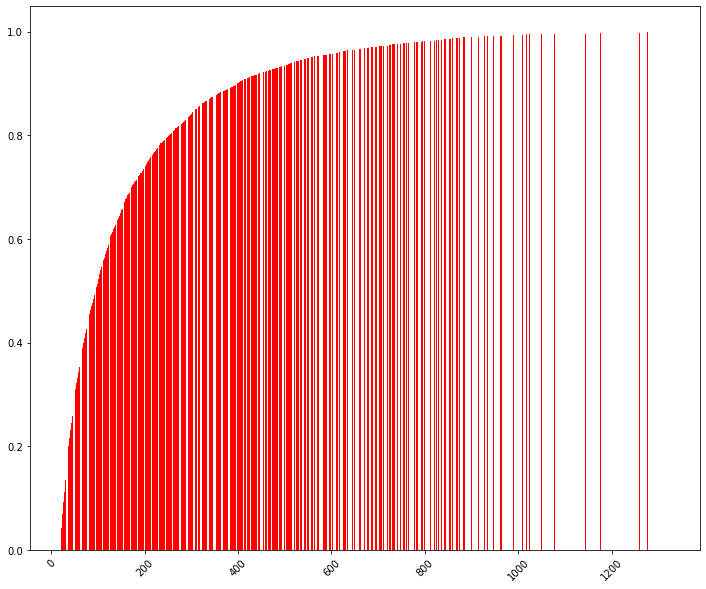

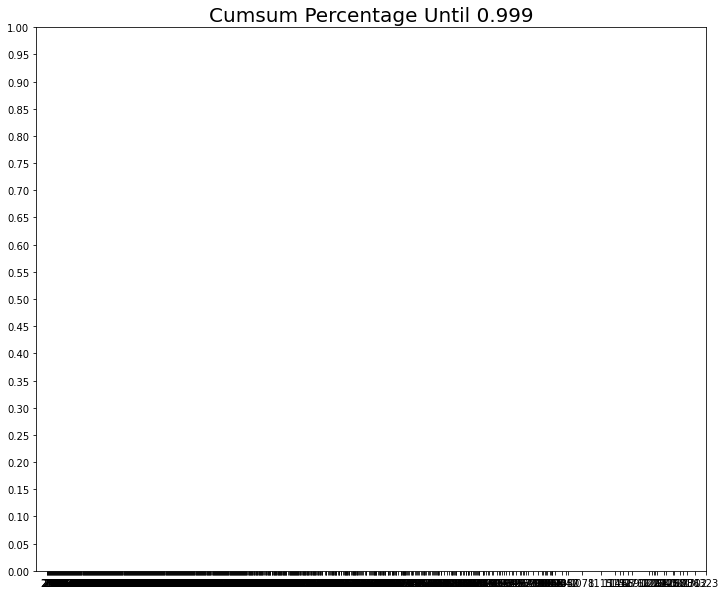

In [21]:
# 이게 젤 낫긴한데 title등의 옵션이사라져버림 ㅎㅎ
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1)

# ax.bar([i for i in range(len(length_percent_cumsum_999.index))], 
#        length_percent_cumsum_999, label='Session길이 누적합')

plt.figure(figsize=(12, 10))
ax.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red', label='Session길이 누적합')
plt.xticks(length_percent_cumsum_999.index)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)

plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

# session 길이가 2미만인 그룹  & 177이상인 그룹 & Rating < 3인 그룹 삭제

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, longest, least_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_unpopular_item(data, least_rating)
        data = cleanse_short_session(data, shortest)
        data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len < longest].index
    data = data[data['UserId'].isin(session_use)]
    return data

# def cleanse_unpopular_item(data: pd.DataFrame, least_rating):
#     item_popular = data.groupby('ItemId').size()
#     item_use = item_popular[item_popular >= least_rating].index
#     data = data[data['Rating'].isin(item_use)]
#     return data


def cleanse_unpopular_item(data: pd.DataFrame, least_rating):
    data = data[data['Rating']>=least_rating]
    return data

In [23]:
data = cleanse_recursive(data, shortest=2, longest=177, least_rating=3)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
999863,6039,1081,4,2000-04-25 23:39:49
999864,6039,1083,3,2000-04-25 23:40:51
999865,6039,1086,4,2000-04-25 23:43:02
999866,6039,1088,4,2000-04-25 23:40:19


# 너무 긴 세션을 삭제했더니 전체 컬럼 길이가 너무 짧아져서 후에 삭제해야 할 수도 있을 것 같습니다,,

- cleanse_long_session 주석처리할 경우 : 836477 
- cleanse_long_session 사용할 경우 :308506 

In [24]:
data['Rating'].describe()

count    308506.000000
mean          4.043853
std           0.767743
min           3.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64


# 1-4.  Train / Valid / Test split

`date['TIme']`컬럼을 일자별 데이터로 변경

In [25]:
data['Time']

0         2000-12-31 22:12:40
1         2000-12-31 22:35:09
2         2000-12-31 22:32:48
3         2000-12-31 22:04:35
4         2001-01-06 23:38:11
                 ...         
999863    2000-04-25 23:39:49
999864    2000-04-25 23:40:51
999865    2000-04-25 23:43:02
999866    2000-04-25 23:40:19
999867    2000-04-25 23:36:51
Name: Time, Length: 308506, dtype: object

In [26]:
test_time = pd.to_datetime(data['Time'])
test_time = test_time.dt.date

In [27]:
test_time

0         2000-12-31
1         2000-12-31
2         2000-12-31
3         2000-12-31
4         2001-01-06
             ...    
999863    2000-04-25
999864    2000-04-25
999865    2000-04-25
999866    2000-04-25
999867    2000-04-25
Name: Time, Length: 308506, dtype: object

In [28]:
data['Time'] = test_time
del test_time

In [29]:
data['Time'].max()

datetime.date(2003, 2, 27)

In [30]:
data['Time'].describe()

count         308506
unique           901
top       2000-11-20
freq           23211
Name: Time, dtype: object

In [31]:
couted_date = data.groupby('Time').size()

In [32]:
couted_date

Time
2000-04-25     118
2000-04-26    1784
2000-04-27     618
2000-04-28     605
2000-04-29     375
              ... 
2003-02-21      27
2003-02-22       2
2003-02-24      17
2003-02-25       2
2003-02-27       2
Length: 901, dtype: int64

In [33]:
couted_date = pd.DataFrame(couted_date)
couted_date

,0
Time,
2000-04-25,118
2000-04-26,1784
2000-04-27,618
2000-04-28,605
2000-04-29,375
...,...
2003-02-21,27
2003-02-22,2
2003-02-24,17


In [34]:
date_index = couted_date.index
date_index

Index([2000-04-25, 2000-04-26, 2000-04-27, 2000-04-28, 2000-04-29, 2000-04-30,
       2000-05-01, 2000-05-02, 2000-05-03, 2000-05-04,
       ...
       2003-02-14, 2003-02-15, 2003-02-16, 2003-02-17, 2003-02-20, 2003-02-21,
       2003-02-22, 2003-02-24, 2003-02-25, 2003-02-27],
      dtype='object', name='Time', length=901)

In [35]:
date_values = couted_date.values
date_values.reshape(len(date_index))

array([  118,  1784,   618,   605,   375,    87,  1133,   759,   911,
         814,   564,   263,   370,   689,  1042,   331,   471,  1333,
         344,   494,   340,   840,  1440,   615,   607,   667,   679,
         453,   508,   819,  1663,   946,   314,   654,   878,   819,
         819,  1102,  1443,   819,   497,   460,  1297,   474,   344,
         372,   950,   892,   409,   722,   359,   888,   633,   357,
         376,   628,   613,   763,   804,   493,   425,   657,   706,
         452,   266,   402,  1041,  1374,  1746,  4285,  1748,  1825,
        1318,  1442,   948,   261,   595,   777,   632,   555,   939,
         756,   290,   667,   409,   906,   591,  1301,   299,   476,
         824,   663,   326,   787,   333,   211,   701,  2107,  3076,
        4008,  8399,  2702,  2638,  1309,  2134,  2680,  2159,  1626,
        2300,  1300,  1555,  1100,  1782,  1214,   612,  1965,   719,
        1137,   929,   829,  1168,   816,   898,   915,  1082,   587,
         911,   543,

- train / valid / test 로 나누기 위해 각 날짜 별 데이터의 수를 histogram으로 그려보앗습니다. --> 더해봐야함 ㅠ_ㅠ

In [36]:
# plt.bar(len(date_index),date_values.astype('int'))
# plt.xticks(len(date_index), date_index)
# plt.show()

In [37]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [38]:
tr, test = split_by_date(data, n_days=31)
tr, val = split_by_date(tr, n_days=31)

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'

In [ ]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

In [ ]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [ ]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# step 2. 미니배치 구성

In [ ]:
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

In [ ]:
tr_dataset.click_offsets


In [ ]:
tr_dataset.session_idx


# 회고
1. 처음에 UTC TIME으로 작성된 시간을 변환하는데 많은 어려움을 겪었습니다.

`test_time = pd.to_datetime(data['Time'])`과 from datetime import datetime 해서 `dt.fromtimestamp((time))` 이코드의 차이는 뭘까

전자로하니 1970-01-01로 전체 날짜가 변경되어 많은 혼란이있었습니다.

2. Datathon의 영향으로, x축의 라벨값을 좋게 보여주려고 코드를 수정했는데, ax와 plt의 차이를 더 공부해야겠습니다. ~~seaborn만 사용했더니만,, matplotlib는 어렵네요ㅠㅠ~~

# 더 공부하고 싶은것

### 데이터톤을 하고 난 이후 시각화에 관심이 많아졌습니다.

1. barchart에서 x축 범위는 일정하게 나눠보여주고, 그래프는 그대로보였으면좋겠다. 그리고 글자가 안곂쳤으면 좋겠다.

In [ ]:
# 그래프가 달라졌음 ㅠ x축 바뀐거도없음
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# plt.bar(x=length_percent_cumsum_999.index,
#         height=length_percent_cumsum_999, color='red')
plt.bar(range(len(length_percent_cumsum_999)),
        length_percent_cumsum_999, color='red')
# plt.xlabel(length_percent_cumsum_999.index)
plt.xticks(length_percent_cumsum_999.index, fontsize=10, rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [ ]:
# 이게 젤 낫긴한데 title등의 옵션이사라져버림 ㅎㅎ
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1)

# ax.bar([i for i in range(len(length_percent_cumsum_999.index))], 
#        length_percent_cumsum_999, label='Session길이 누적합')

plt.figure(figsize=(12, 10))
ax.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red', label='Session길이 누적합')
plt.xticks(length_percent_cumsum_999.index)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)

plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [ ]:
# 글자곂침해결해ㅏ,,
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
# plt.xlabel(length_percent_cumsum_999.index)
plt.xticks(length_percent_cumsum_999.index, fontsize=10, rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

2. train / valid / test 로 나누기 위해 각 날짜 별 데이터의 수를 histogram으로 그려보기

In [ ]:
plt.bar(len(date_index),date_values.astype('int'))
plt.xticks(len(date_index), date_index)
plt.show()